<a href="https://colab.research.google.com/github/Medynal/Pollution/blob/main/pollution_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os

repo_url = "https://github.com/Medynal/Pollution.git"
folder_path = "/content/Pollution"

if not os.path.exists(folder_path):
  !git clone {repo_url} {folder_path}
print(f"Current working directory: {os.getcwd()}")


Current working directory: /content


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
import joblib

In [19]:
cpollution_df = pd.read_csv('/content/Pollution/cleaned_pollution_dataset.csv', parse_dates=['Date']).drop(['Month name', 'Date'], axis= 1)
cpollution_df.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,year,month,day
0,Ahmedabad,73.24,141.54,0.92,18.22,17.15,26.64,0.92,27.64,133.36,0.00,0.02,0.00,209.0,Poor,2015,1,1
1,Ahmedabad,73.24,141.54,0.97,15.69,16.46,26.64,0.97,24.55,34.06,3.68,5.50,3.77,209.0,Poor,2015,1,2
2,Ahmedabad,73.24,141.54,17.40,19.30,29.70,26.64,17.40,29.07,30.70,6.80,16.40,2.25,209.0,Poor,2015,1,3
3,Ahmedabad,73.24,141.54,1.70,18.48,17.97,26.64,1.70,18.59,36.08,4.43,10.14,1.00,209.0,Poor,2015,1,4
4,Ahmedabad,73.24,141.54,22.10,21.42,37.76,26.64,22.10,39.33,39.31,7.01,18.89,2.78,209.0,Poor,2015,1,5


In [20]:
#Cyclical Transformation
# Month
cpollution_df['month_sin'] = np.sin(2 * np.pi * cpollution_df['month']/12)
cpollution_df['month_cos'] = np.cos(2 * np.pi * cpollution_df['month']/12)
# Day
cpollution_df['day_sin'] = np.sin(2 * np.pi * cpollution_df['day']/7)
cpollution_df['day_cos'] = np.cos(2 * np.pi * cpollution_df['day']/7)

#encoding AQI bucket
bucket_encoder = LabelEncoder()
cpollution_df['AQI_Bucket_encoded'] = bucket_encoder.fit_transform(cpollution_df['AQI_Bucket'])

In [22]:
cpollution_df.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,...,AQI,AQI_Bucket,year,month,day,month_sin,month_cos,day_sin,day_cos,AQI_Bucket_encoded
0,Ahmedabad,73.24,141.54,0.92,18.22,17.15,26.64,0.92,27.64,133.36,...,209.0,Poor,2015,1,1,0.5,0.866025,0.781831,0.623490,2
1,Ahmedabad,73.24,141.54,0.97,15.69,16.46,26.64,0.97,24.55,34.06,...,209.0,Poor,2015,1,2,0.5,0.866025,0.974928,-0.222521,2
2,Ahmedabad,73.24,141.54,17.40,19.30,29.70,26.64,17.40,29.07,30.70,...,209.0,Poor,2015,1,3,0.5,0.866025,0.433884,-0.900969,2
3,Ahmedabad,73.24,141.54,1.70,18.48,17.97,26.64,1.70,18.59,36.08,...,209.0,Poor,2015,1,4,0.5,0.866025,-0.433884,-0.900969,2
4,Ahmedabad,73.24,141.54,22.10,21.42,37.76,26.64,22.10,39.33,39.31,...,209.0,Poor,2015,1,5,0.5,0.866025,-0.974928,-0.222521,2


In [33]:
pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']
labels = ['City','year','month_sin','month_cos', 'day_sin', 'day_cos'] + pollutants
X = cpollution_df[labels]
y_reg = cpollution_df['AQI']
y_clf = cpollution_df['AQI_Bucket_encoded']

In [34]:
# Train-test split
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split( X, y_reg, y_clf, test_size=0.2, random_state=42)

In [35]:
preprocessor = ColumnTransformer(transformers=[('city', OneHotEncoder(handle_unknown='ignore'), ['City']),
        ('others', 'passthrough', ['year','month_sin','month_cos', 'day_sin', 'day_cos'] + pollutants)])

In [36]:
#regression pipeline to predict AQI
reg_pipeline = Pipeline([('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42))])

reg_pipeline.fit(X_train, y_reg_train)
y_reg_pred = reg_pipeline.predict(X_test)
print('Regression MAE:', mean_absolute_error(y_reg_test, y_reg_pred))
print('Regression R2 :', r2_score(y_reg_test, y_reg_pred))


Regression MAE: 19.086069098809322
Regression R2 : 0.9038168751308777


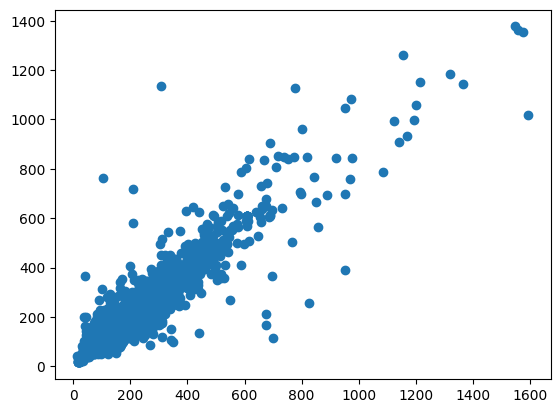

In [37]:
import matplotlib.pyplot as plt
plt.scatter(x= y_reg_test, y= y_reg_pred)
plt.show()

In [38]:
#classification pipeline to predict AQI_Bucket
clf_pipeline = Pipeline([('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))])

clf_pipeline.fit(X_train, y_clf_train)
y_clf_pred = clf_pipeline.predict(X_test)
print('Classification accuracy:', accuracy_score(y_clf_test, y_clf_pred))
print('Classification report:\n', classification_report(y_clf_test, y_clf_pred))
print('Confusion matrix:\n', confusion_matrix(y_clf_test, y_clf_pred))

Classification accuracy: 0.8286778398510242
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.68      0.76       296
           1       0.82      0.87      0.84      2062
           2       0.74      0.67      0.70       666
           3       0.87      0.88      0.87      2033
           4       0.88      0.76      0.82       302
           5       0.78      0.79      0.78       548

    accuracy                           0.83      5907
   macro avg       0.83      0.78      0.80      5907
weighted avg       0.83      0.83      0.83      5907

Confusion matrix:
 [[ 202    5    0   88    0    1]
 [   3 1797   71  183    2    6]
 [   0  158  444    2    0   62]
 [  28  216    2 1787    0    0]
 [   0    4   11    0  230   57]
 [   0   15   69    1   28  435]]


In [39]:
os.makedirs('models', exist_ok=True)
joblib.dump(reg_pipeline, 'models/aqi_regressor.pkl')
joblib.dump(clf_pipeline, 'models/aqi_classifier.pkl')
joblib.dump(bucket_encoder, 'models/bucket_encoder.pkl')
print('Models saved in models/ folder')

Models saved in models/ folder


In [41]:
!pip -q install streamlit
print('Done!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.8 MB/s eta 0:00:00
Done!


In [42]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from datetime import datetime



In [43]:
#loading Models
aqi_pipeline = joblib.load('/content/models/aqi_regressor.pkl')
aqib_pipeline = joblib.load('/content/models/aqi_classifier.pkl')
bucket_encoder = joblib.load('/content/models/bucket_encoder.pkl')



In [ ]:
st.title('AQI & AQI Bucket Predictor')

city_list = ['Ahmedabad', 'Aizawl', 'Amaravati', 'Amritsar', 'Bengaluru', 'Bhopal', 'Brajrajnagar', 'Chandigarh', 'Chennai', 'Coimbatore', 'Delhi', 'Ernakulam', 'Gurugram', 'Guwahati', 'Hyderabad', 'Jaipur', 'Jorapokhar', 'Kochi', 'Kolkata',
 'Lucknow', 'Mumbai', 'Patna', 'Shillong', 'Talcher', 'Thiruvananthapuram', 'Visakhapatnam']

city = st.selectbox('Select City', options=city_list)
date_input = st.date_input('Select Date', datetime.today())

# Pollutant inputs
pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']
pollutant_values = {}
st.write("### Enter pollutant concentrations")
for p in pollutants:
    pollutant_values[p] = st.number_input(p, min_value=0.0, value=10.0, step=1.0)

# Extract Year, Month, Day
year = date_input.year
month = date_input.month
dayofweek = date_input.weekday()

# Apply cyclical transformation
month_sin = np.sin(2*np.pi*month/12)
month_cos = np.cos(2*np.pi*month/12)
dow_sin = np.sin(2*np.pi*dayofweek/7)
dow_cos = np.cos(2*np.pi*dayofweek/7)

# Prepare input dataframe
input_df = pd.DataFrame({
    'City': [city],
    'Year': [year],
    'Month_sin': [month_sin],
    'Month_cos': [month_cos],
    'DayOfWeek_sin': [dow_sin],
    'DayOfWeek_cos': [dow_cos],
    **{k:[v] for k,v in pollutant_values.items()}
})

# Predict AQI
pred_aqi = reg_pipeline.predict(input_df)[0]
pred_bucket_encoded = clf_pipeline.predict(input_df)[0]
pred_bucket = bucket_encoder.inverse_transform([pred_bucket_encoded])[0]

# Display results
st.write(f"### Predicted AQI: {pred_aqi:.2f}")
st.write(f"### Predicted AQI Bucket: {pred_bucket}")